  # Metrics for hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

  ### Definition of names for plots and files

In [2]:

date = '20200609'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'



### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_feat_for_stats = df_feat.copy()
print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[df_labels['source']!="ASASSN"]

df_labels = df_labels[(df_labels['class_source']!="ELL")]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova','LPV',
               'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(171284,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
'W1-W2','W2-W3','r-W3','r-W2','g-W3','g-W2',    
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

122531
122531
122531
122531


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,10.0,16.0,2.0,4.0,1.000000,1.0,0.780000,0.013542,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,16.0,0.0,0.0,23.0,0.285714,1.0,0.717857,0.216488,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,7.0,0.0,1.0,17.0,1.000000,1.0,0.683333,0.088542,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,2.0,0.0,6.0,6.0,0.000000,0.0,0.683333,0.035875,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.0,4.0,7.0,0.0,1.000000,1.0,0.683333,0.161542,-999.000000,0.277404


In [6]:
print(df.columns)

Index(['Amplitude_1', 'Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2',
       'Autocor_length_1', 'Autocor_length_2', 'Beyond1Std_1', 'Beyond1Std_2',
       'Con_1', 'Con_2',
       ...
       'n_non_det_after_fid_1', 'n_non_det_after_fid_2',
       'n_non_det_before_fid_1', 'n_non_det_before_fid_2',
       'positive_fraction_1', 'positive_fraction_2', 'rb', 'sgscore1',
       'delta_period_1', 'delta_period_2'],
      dtype='object', length=146)


In [7]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 26168
AGN 4667
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 291


  ### Defining functions to plot the confusion matrix and the feature importance

In [8]:
'''def plot_confusion_matrix(cm,cm_low,cm_high, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,font=20,fig_x = 20, fig_y = 12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm_aux = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_low = np.round((cm_low.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_high = np.round((cm_high.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm = cm_aux
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = font)
    plt.yticks(tick_marks, classes, fontsize = font)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
        plt.text(j, i,r"$%d^{+%d}_{-%d}$"%  (cm[i, j],cm[i, j]-cm_low[i, j],cm_high[i, j]-cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = font)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = font+2)
    plt.xlabel('Predicted label',fontsize = font+2)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()'''
    
    
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [9]:
def compute_accuracy_periodic_transient_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        
        
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''        
        
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]

        #Transients (all together)
        
        #df_test_1band_aux_AQB = df_test_1band_aux.iloc[(np.flatnonzero(np.core.defchararray.find(df_test_1band_aux['class_original'].values,"SN")!=-1)),:]                                                                                           
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]     
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII")  | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII")  | (pred_y_AQB=="SLSN"))]="SN"
            print(bins_mag[i])
            print("true SN: ",true_y_AQB)
            print("pred SN: ",pred_y_AQB)       
            
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"

                                                                     

            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
            
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='EB']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        true_y_AGN[np.where((true_y_AGN!="EB"))]="Other"
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        pred_y_AGN[np.where((pred_y_AGN!="EB"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="EB")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        #print("True AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''



        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='Ceph']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="Ceph"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="Ceph"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="Ceph")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        '''
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='RSCVn']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="RSCVn"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="RSCVn"))]="Other"
        print("bin ",bins_mag[i])
        print("true RSCVn", true_y_YSO)
        print("pred RSCVn", pred_y_YSO)
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="RSCVn")
        print("acc", acc_YSO)
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        '''
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    #acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    #nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    #return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [10]:
def compute_accuracy_stochastic_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        
        
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''        
        
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]

        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        #print("True AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''



        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [11]:
def compute_accuracy_stochastic_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [12]:
def compute_accuracy_periodic_transient_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #Transients (all together)
        

        #df_test_1band_aux_AQB = df_test_1band_aux.iloc[(np.flatnonzero(np.core.defchararray.find(df_test_1band_aux['class_original'].values,"SN")!=-1)),:]                                                                                           
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]            
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII") | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII") | (pred_y_AQB=="SLSN"))]="SN"
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"
            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='EB']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="EB"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="EB"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="EB")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='Ceph']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="Ceph"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="Ceph"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="Ceph")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        '''
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='RSCVn']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="RSCVn"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="RSCVn"))]="Other"
        print("bin ",bins_mag[i])
        print("true RSCVn", true_y_YSO)
        print("pred RSCVn", pred_y_YSO)
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="RSCVn")
        print("acc", acc_YSO)
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        '''
        
        #CV/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    #acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    #nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    print(acc_mag_1band_YSO)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    #return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)





In [13]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df.copy()#.columns.values.tolist()
#X_hierarchical = X_hierarchical.drop(['n_det_1','n_det_2'])

#splitting training set
#X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
#Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)
splitted_set = sss.split(X_hierarchical, Y_original)


rf_model_hierarchical = RandomForestClassifier(
                n_estimators=500,
                max_features='auto',
                max_depth=None,
                n_jobs=-1,
                bootstrap=True,
                class_weight='balanced_subsample',
                criterion='entropy',
                min_samples_split=2,
                min_samples_leaf=1)


rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


ind = 0
list_Accuracy_first_layer = []
list_Balanced_Accuracy_first_layer = []
list_precision_first_layer = []
list_recall_first_layer = []
list_F1_Accuracy_first_layer = []

list_Accuracy_last_layer = []
list_Balanced_Accuracy_last_layer = []
list_precision_last_layer = []
list_recall_last_layer = []
list_F1_Accuracy_last_layer = []

list_cnf_matrix = []

list_cnf_matrix_hier = []

list_acc_mag_rband_AQB = []
list_acc_mag_rband_AGN = []
list_acc_mag_rband_QSO = []
list_acc_mag_rband_Blazar = []
list_acc_mag_rband_YSO = []
list_acc_mag_rband_CV = []
list_acc_mag_rband_LPV = []

list_acc_mag_gband_AQB = []
list_acc_mag_gband_AGN = []
list_acc_mag_gband_QSO = []
list_acc_mag_gband_Blazar = []
list_acc_mag_gband_YSO = []
list_acc_mag_gband_CV = []
list_acc_mag_gband_LPV = []

list_acc_nsamp_rband_AQB = []
list_acc_nsamp_rband_AGN = []
list_acc_nsamp_rband_QSO = []
list_acc_nsamp_rband_Blazar = []
list_acc_nsamp_rband_YSO = []
list_acc_nsamp_rband_CV = []
list_acc_nsamp_rband_LPV = []

list_acc_nsamp_gband_AQB = []
list_acc_nsamp_gband_AGN = []
list_acc_nsamp_gband_QSO = []
list_acc_nsamp_gband_Blazar = []
list_acc_nsamp_gband_YSO = []
list_acc_nsamp_gband_CV = []
list_acc_nsamp_gband_LPV = []

list_acc_mag_grband_AQB = []
list_acc_mag_grband_AGN = []
list_acc_mag_grband_QSO = []
list_acc_mag_grband_Blazar = []
list_acc_mag_grband_YSO = []
list_acc_mag_grband_CV = []
list_acc_mag_grband_LPV = []

list_acc_nsamp_grband_AQB = []
list_acc_nsamp_grband_AGN = []
list_acc_nsamp_grband_QSO = []
list_acc_nsamp_grband_Blazar = []
list_acc_nsamp_grband_YSO = []
list_acc_nsamp_grband_CV = []
list_acc_nsamp_grband_LPV = []

##

list_nsamp_mag_rband_AQB = []
list_nsamp_mag_rband_AGN = []
list_nsamp_mag_rband_QSO = []
list_nsamp_mag_rband_Blazar = []
list_nsamp_mag_rband_YSO = []
list_nsamp_mag_rband_CV = []
list_nsamp_mag_rband_LPV = []

list_nsamp_mag_gband_AQB = []
list_nsamp_mag_gband_AGN = []
list_nsamp_mag_gband_QSO = []
list_nsamp_mag_gband_Blazar = []
list_nsamp_mag_gband_YSO = []
list_nsamp_mag_gband_CV = []
list_nsamp_mag_gband_LPV = []

list_nsamp_nsamp_rband_AQB = []
list_nsamp_nsamp_rband_AGN = []
list_nsamp_nsamp_rband_QSO = []
list_nsamp_nsamp_rband_Blazar = []
list_nsamp_nsamp_rband_YSO = []
list_nsamp_nsamp_rband_CV = []
list_nsamp_nsamp_rband_LPV = []

list_nsamp_nsamp_gband_AQB = []
list_nsamp_nsamp_gband_AGN = []
list_nsamp_nsamp_gband_QSO = []
list_nsamp_nsamp_gband_Blazar = []
list_nsamp_nsamp_gband_YSO = []
list_nsamp_nsamp_gband_CV = []
list_nsamp_nsamp_gband_LPV = []

list_nsamp_mag_grband_AQB = []
list_nsamp_mag_grband_AGN = []
list_nsamp_mag_grband_QSO = []
list_nsamp_mag_grband_Blazar = []
list_nsamp_mag_grband_YSO = []
list_nsamp_mag_grband_CV = []
list_nsamp_mag_grband_LPV = []

list_nsamp_nsamp_grband_AQB = []
list_nsamp_nsamp_grband_AGN = []
list_nsamp_nsamp_grband_QSO = []
list_nsamp_nsamp_grband_Blazar = []
list_nsamp_nsamp_grband_YSO = []
list_nsamp_nsamp_grband_CV = []
list_nsamp_nsamp_grband_LPV = []

##

list_acc_mag_rband_transients = []
list_acc_mag_rband_EB = []
list_acc_mag_rband_DSCT = []
list_acc_mag_rband_RRL = []
list_acc_mag_rband_Ceph = []
#list_acc_mag_rband_RSCVn = []
list_acc_mag_rband_Other = []

list_acc_mag_gband_transients = []
list_acc_mag_gband_EB = []
list_acc_mag_gband_DSCT = []
list_acc_mag_gband_RRL = []
list_acc_mag_gband_Ceph = []
#list_acc_mag_gband_RSCVn = []
list_acc_mag_gband_Other = []

list_acc_nsamp_rband_transients = []
list_acc_nsamp_rband_EB = []
list_acc_nsamp_rband_DSCT = []
list_acc_nsamp_rband_RRL = []
list_acc_nsamp_rband_Ceph = []
#list_acc_nsamp_rband_RSCVn = []
list_acc_nsamp_rband_Other = []

list_acc_nsamp_gband_transients = []
list_acc_nsamp_gband_EB = []
list_acc_nsamp_gband_DSCT = []
list_acc_nsamp_gband_RRL = []
list_acc_nsamp_gband_Ceph = []
#list_acc_nsamp_gband_RSCVn = []
list_acc_nsamp_gband_Other = []

list_acc_mag_grband_transients = []
list_acc_mag_grband_EB = []
list_acc_mag_grband_DSCT = []
list_acc_mag_grband_RRL = []
list_acc_mag_grband_Ceph = []
#list_acc_mag_grband_RSCVn = []
list_acc_mag_grband_Other = []

list_acc_nsamp_grband_transients = []
list_acc_nsamp_grband_EB = []
list_acc_nsamp_grband_DSCT = []
list_acc_nsamp_grband_RRL = []
list_acc_nsamp_grband_Ceph = []
#list_acc_nsamp_grband_RSCVn = []
list_acc_nsamp_grband_Other = []

##

list_nsamp_mag_rband_transients = []
list_nsamp_mag_rband_EB = []
list_nsamp_mag_rband_DSCT = []
list_nsamp_mag_rband_RRL = []
list_nsamp_mag_rband_Ceph = []
#list_nsamp_mag_rband_RSCVn = []
list_nsamp_mag_rband_Other = []

list_nsamp_mag_gband_transients = []
list_nsamp_mag_gband_EB = []
list_nsamp_mag_gband_DSCT = []
list_nsamp_mag_gband_RRL = []
list_nsamp_mag_gband_Ceph = []
#list_nsamp_mag_gband_RSCVn = []
list_nsamp_mag_gband_Other = []

list_nsamp_nsamp_rband_transients = []
list_nsamp_nsamp_rband_EB = []
list_nsamp_nsamp_rband_DSCT = []
list_nsamp_nsamp_rband_RRL = []
list_nsamp_nsamp_rband_Ceph = []
#list_nsamp_nsamp_rband_RSCVn = []
list_nsamp_nsamp_rband_Other = []

list_nsamp_nsamp_gband_transients = []
list_nsamp_nsamp_gband_EB = []
list_nsamp_nsamp_gband_DSCT = []
list_nsamp_nsamp_gband_RRL = []
list_nsamp_nsamp_gband_Ceph = []
#list_nsamp_nsamp_gband_RSCVn = []
list_nsamp_nsamp_gband_Other = []

list_nsamp_mag_grband_transients = []
list_nsamp_mag_grband_EB = []
list_nsamp_mag_grband_DSCT = []
list_nsamp_mag_grband_RRL = []
list_nsamp_mag_grband_Ceph = []
#list_nsamp_mag_grband_RSCVn = []
list_nsamp_mag_grband_Other = []

list_nsamp_nsamp_grband_transients = []
list_nsamp_nsamp_grband_EB = []
list_nsamp_nsamp_grband_DSCT = []
list_nsamp_nsamp_grband_RRL = []
list_nsamp_nsamp_grband_Ceph = []
#list_nsamp_nsamp_grband_RSCVn = []
list_nsamp_nsamp_grband_Other = []

##



for train_index, test_index in splitted_set:
    print("iteration ", ind)
    X_train_hierarchical, X_test_hierarchical = X_hierarchical.iloc[train_index], X_hierarchical.iloc[test_index]
    y_train_original, y_test_original = Y_original.iloc[train_index], Y_original.iloc[test_index]
    y_train_hierarchical, y_test_hierarchical = Y_hierarchical.iloc[train_index], Y_hierarchical.iloc[test_index]
    
    X_test_hierarchical_for_stats = X_test_hierarchical.copy()
    X_test_hierarchical_for_stats = X_test_hierarchical_for_stats.join(df_feat_for_stats.loc[:,['n_det_1','n_det_2']],how='left')
    
    
    # separating training sets for sub-classes
    X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
    #X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
    y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

    X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
    y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

    X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
    #X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
    y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

    #X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

    X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    #X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    
    print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))
    
    #Training first layer of the RF model

    rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

    #testing first layer performance

    y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
    y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

    classes_order_proba_hierarchical = rf_model_hierarchical.classes_

    acc_h = metrics.accuracy_score(y_true, y_pred)
    balandec_acc_h = metrics.balanced_accuracy_score(y_true, y_pred)
    pres_h = metrics.precision_score(y_true, y_pred, average='macro')
    rec_h = metrics.recall_score(y_true, y_pred, average='macro')
    f1_h = metrics.f1_score(y_true, y_pred, average='macro')
    
    list_Accuracy_first_layer.append(acc_h)
    list_Balanced_Accuracy_first_layer.append(balandec_acc_h)
    list_precision_first_layer.append(pres_h)
    list_recall_first_layer.append(rec_h)
    list_F1_Accuracy_first_layer.append(f1_h)
    
    print("F1:", acc_h)
    print("Balanced accuracy:", balandec_acc_h)
    
    cnf_matrix_hier = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
    print(cnf_matrix_hier)
    list_cnf_matrix_hier.append(cnf_matrix_hier)
    #Training Periodic layer
    rf_model_periodic.fit(X_train_periodic, y_train_periodic)

    # Applying periodic model to the test data
    y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
    y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)
    
    classes_order_proba_periodic = rf_model_periodic.classes_
    
    #Training Stochastic layer
    rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

    # Applying stochastic model to the test data
    y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
    y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)
    
    classes_order_proba_stochastic = rf_model_stochastic.classes_
    
    #Training Transient layer
    rf_model_transient.fit(X_train_transient, y_train_transient)

    # Applying transient model to the test data
    y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
    y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

    classes_order_proba_transient = rf_model_transient.classes_
    
    # generating final probabilities

    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

    print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

    #getting the ordered name of classes for prob_final
    prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
    print(prob_final_class_names)


    class_final_proba = np.amax(prob_final,axis=1)
    class_final_index = np.argmax(prob_final,axis=1)
    class_final_name = [prob_final_class_names[x] for x in class_final_index]
    
    class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])
    
    cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
    #print(cnf_matrix)
    list_cnf_matrix.append(cnf_matrix)
    
    acc = metrics.accuracy_score(y_test_original, class_final_name)
    balanced_acc = metrics.balanced_accuracy_score(y_test_original, class_final_name)
    pres = metrics.precision_score(y_test_original, class_final_name, average='macro')
    rec = metrics.recall_score(y_test_original, class_final_name, average='macro')
    f1 = metrics.f1_score(y_test_original, class_final_name, average='macro')
    
    list_Accuracy_last_layer.append(acc)
    list_Balanced_Accuracy_last_layer.append(balanced_acc)
    list_precision_last_layer.append(pres)
    list_recall_last_layer.append(rec)
    list_F1_Accuracy_last_layer.append(f1)
    
    print("Accuracy:", acc)
    print("Balanced accuracy:", balanced_acc)
    print("macro precision: ", pres)
    print("macro F1: ", f1)
    
    
    #####
    #####
    
    #balanced accuracy curves
    
    #selecting sources with info in both bands
    X_test_hierarchical_gr = X_test_hierarchical_for_stats.join(df_feat[['Mean_1','Mean_2']],how='left')

    X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['n_det_1']>5) & (X_test_hierarchical_gr['n_det_2']>5)]
    y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]
    y_test_hierarchical_gr = y_test_hierarchical[X_test_hierarchical_gr.index]
    class_final_name_gr = class_final_name_df.loc[X_test_hierarchical_gr.index]
    
    print(len(X_test_hierarchical_gr.columns),len(y_test_original_gr),len(y_test_hierarchical_gr))

    #stochastics
    bins_mag_gr,nsamples_AQB,acc_mag_grband_AQB,nsamples_AGN,acc_mag_grband_AGN,nsamples_QSO,acc_mag_grband_QSO,nsamples_Blazar,acc_mag_grband_Blazar,nsamples_YSO,acc_mag_grband_YSO,nsamples_CV,acc_mag_grband_CV,nsamples_LPV,acc_mag_grband_LPV = compute_accuracy_stochastic_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_AQB,acc_nsamp_grband_AQB,nsamp_nsamples_AGN,acc_nsamp_grband_AGN,nsamp_nsamples_QSO,acc_nsamp_grband_QSO,nsamp_nsamples_Blazar,acc_nsamp_grband_Blazar,nsamp_nsamples_YSO,acc_nsamp_grband_YSO,nsamp_nsamples_CV,acc_nsamp_grband_CV,nsamp_nsamples_LPV,acc_nsamp_grband_LPV = compute_accuracy_stochastic_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)

    #periodic+transients
    bins_mag_gr,nsamples_transients,acc_mag_grband_transients,nsamples_EB,acc_mag_grband_EB,nsamples_DSCT,acc_mag_grband_DSCT,nsamples_RRL,acc_mag_grband_RRL,nsamples_Other,acc_mag_grband_Other,nsamples_Ceph,acc_mag_grband_Ceph = compute_accuracy_periodic_transient_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_transients,acc_nsamp_grband_transients,nsamp_nsamples_EB,acc_nsamp_grband_EB,nsamp_nsamples_DSCT,acc_nsamp_grband_DSCT,nsamp_nsamples_RRL,acc_nsamp_grband_RRL,nsamp_nsamples_Other,acc_nsamp_grband_Other,nsamp_nsamples_Ceph,acc_nsamp_grband_Ceph = compute_accuracy_periodic_transient_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)


    r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
    g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]

    #####
    
    #modelling just with g band
    X_test_hierarchical_g = X_test_hierarchical_gr.copy()
    X_test_hierarchical_g[r_feat] = -999
    X_test_hierarchical_g = X_test_hierarchical_g.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_g, y_pred_g = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_g)
    y_pred_proba_hier_g = rf_model_hierarchical.predict_proba(X_test_hierarchical_g)
    
    y_true_periodic_g, y_pred_periodic_g = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_g)
    y_pred_proba_periodic_g = rf_model_periodic.predict_proba(X_test_hierarchical_g)
    
    y_true_stochastic_g, y_pred_stochastic_g  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_g)
    y_pred_proba_stochastic_g = rf_model_stochastic.predict_proba(X_test_hierarchical_g)
    
    y_true_transient_g, y_pred_transient_g  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_g)
    y_pred_proba_transient_g = rf_model_transient.predict_proba(X_test_hierarchical_g)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_g = y_pred_proba_periodic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_g = y_pred_proba_stochastic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_g = y_pred_proba_transient_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_g = np.concatenate((prob_stochastic_g,prob_trainsient_g,prob_periodic_g),axis=1)

    print(np.sum(prob_final_g,axis=1),np.mean(np.sum(prob_final_g,axis=1)),np.std(np.sum(prob_final_g,axis=1)))

    #getting prob_final

    class_final_proba_g = np.amax(prob_final_g,axis=1)
    class_final_index_g = np.argmax(prob_final_g,axis=1)
    class_final_name_g = [prob_final_class_names[x] for x in class_final_index_g]
    
    #computing acc:
    #stochastics
    print("G BAND ######")
    bins_mag_g,nsamples_AQB_g,acc_mag_gband_AQB,nsamples_AGN_g,acc_mag_gband_AGN,nsamples_QSO_g,acc_mag_gband_QSO,nsamples_Blazar_g,acc_mag_gband_Blazar,nsamples_YSO_g,acc_mag_gband_YSO,nsamples_CV_g,acc_mag_gband_CV,nsamples_LPV_g,acc_mag_gband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_AQB_g,acc_nsamp_gband_AQB,nsamp_nsamples_AGN_g,acc_nsamp_gband_AGN,nsamp_nsamples_QSO_g,acc_nsamp_gband_QSO,nsamp_nsamples_Blazar_g,acc_nsamp_gband_Blazar,nsamp_nsamples_YSO_g,acc_nsamp_gband_YSO,nsamp_nsamples_CV_g,acc_nsamp_gband_CV,nsamp_nsamples_LPV_g,acc_nsamp_gband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)

    #periodic+transients
    bins_mag_g,nsamples_transients_g,acc_mag_gband_transients,nsamples_EB_g,acc_mag_gband_EB,nsamples_DSCT_g,acc_mag_gband_DSCT,nsamples_RRL_g,acc_mag_gband_RRL,nsamples_Other_g,acc_mag_gband_Other,nsamples_Ceph_g,acc_mag_gband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_transients_g,acc_nsamp_gband_transients,nsamp_nsamples_EB_g,acc_nsamp_gband_EB,nsamp_nsamples_DSCT_g,acc_nsamp_gband_DSCT,nsamp_nsamples_RRL_g,acc_nsamp_gband_RRL,nsamp_nsamples_Other_g,acc_nsamp_gband_Other,nsamp_nsamples_Ceph_g,acc_nsamp_gband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)


    
    print(acc_mag_gband_AGN,acc_nsamp_gband_AGN)

    #####
    
    #modelling just with r band
    X_test_hierarchical_r = X_test_hierarchical_gr.copy()
    X_test_hierarchical_r[g_feat] = -999
    X_test_hierarchical_r = X_test_hierarchical_r.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_r, y_pred_r = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_r)
    y_pred_proba_hier_r = rf_model_hierarchical.predict_proba(X_test_hierarchical_r)
    
    y_true_periodic_r, y_pred_periodic_r = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_r)
    y_pred_proba_periodic_r = rf_model_periodic.predict_proba(X_test_hierarchical_r)
    
    y_true_stochastic_r, y_pred_stochastic_r  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_r)
    y_pred_proba_stochastic_r = rf_model_stochastic.predict_proba(X_test_hierarchical_r)
    
    y_true_transient_r, y_pred_transient_r  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_r)
    y_pred_proba_transient_r = rf_model_transient.predict_proba(X_test_hierarchical_r)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_r = y_pred_proba_periodic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_r = y_pred_proba_stochastic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_r = y_pred_proba_transient_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_r = np.concatenate((prob_stochastic_r,prob_trainsient_r,prob_periodic_r),axis=1)

    print(np.sum(prob_final_r,axis=1),np.mean(np.sum(prob_final_r,axis=1)),np.std(np.sum(prob_final_r,axis=1)))

    #getting  prob_final
    class_final_proba_r = np.amax(prob_final_r,axis=1)
    class_final_index_r = np.argmax(prob_final_r,axis=1)
    class_final_name_r = [prob_final_class_names[x] for x in class_final_index_r]
    
    #computing acc:
    #stochastics
    print("R BAND ######")
    bins_mag_r,nsamples_AQB_r,acc_mag_rband_AQB,nsamples_AGN_r,acc_mag_rband_AGN,nsamples_QSO_r,acc_mag_rband_QSO,nsamples_Blazar_r,acc_mag_rband_Blazar,nsamples_YSO_r,acc_mag_rband_YSO,nsamples_CV_r,acc_mag_rband_CV,nsamples_LPV_r,acc_mag_rband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_AQB_r,acc_nsamp_rband_AQB,nsamp_nsamples_AGN_r,acc_nsamp_rband_AGN,nsamp_nsamples_QSO_r,acc_nsamp_rband_QSO,nsamp_nsamples_Blazar_r,acc_nsamp_rband_Blazar,nsamp_nsamples_YSO_r,acc_nsamp_rband_YSO,nsamp_nsamples_CV_r,acc_nsamp_rband_CV,nsamp_nsamples_LPV_r,acc_nsamp_rband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)

    #periodic+transients
    bins_mag_r,nsamples_transients_r,acc_mag_rband_transients,nsamples_EB_r,acc_mag_rband_EB,nsamples_DSCT_r,acc_mag_rband_DSCT,nsamples_RRL_r,acc_mag_rband_RRL,nsamples_Other_r,acc_mag_rband_Other,nsamples_Ceph_r,acc_mag_rband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_transients_r,acc_nsamp_rband_transients,nsamp_nsamples_EB_r,acc_nsamp_rband_EB,nsamp_nsamples_DSCT_r,acc_nsamp_rband_DSCT,nsamp_nsamples_RRL_r,acc_nsamp_rband_RRL,nsamp_nsamples_Other_r,acc_nsamp_rband_Other,nsamp_nsamples_Ceph_r,acc_nsamp_rband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)


    list_acc_mag_rband_AQB.append(acc_mag_rband_AQB)
    list_acc_mag_rband_AGN.append(acc_mag_rband_AGN)
    list_acc_mag_rband_QSO.append(acc_mag_rband_QSO)
    list_acc_mag_rband_Blazar.append(acc_mag_rband_Blazar)
    list_acc_mag_rband_YSO.append(acc_mag_rband_YSO)
    list_acc_mag_rband_CV.append(acc_mag_rband_CV)
    list_acc_mag_rband_LPV.append(acc_mag_rband_LPV)

    list_acc_mag_gband_AQB.append(acc_mag_gband_AQB)
    list_acc_mag_gband_AGN.append(acc_mag_gband_AGN)
    list_acc_mag_gband_QSO.append(acc_mag_gband_QSO)
    list_acc_mag_gband_Blazar.append(acc_mag_gband_Blazar)
    list_acc_mag_gband_YSO.append(acc_mag_gband_YSO)
    list_acc_mag_gband_CV.append(acc_mag_gband_CV)
    list_acc_mag_gband_LPV.append(acc_mag_gband_LPV)

    list_acc_nsamp_rband_AQB.append(acc_nsamp_rband_AQB)
    list_acc_nsamp_rband_AGN.append(acc_nsamp_rband_AGN)
    list_acc_nsamp_rband_QSO.append(acc_nsamp_rband_QSO)
    list_acc_nsamp_rband_Blazar.append(acc_nsamp_rband_Blazar)
    list_acc_nsamp_rband_YSO.append(acc_nsamp_rband_YSO)
    list_acc_nsamp_rband_CV.append(acc_nsamp_rband_CV)
    list_acc_nsamp_rband_LPV.append(acc_nsamp_rband_LPV)

    list_acc_nsamp_gband_AQB.append(acc_nsamp_gband_AQB)
    list_acc_nsamp_gband_AGN.append(acc_nsamp_gband_AGN)
    list_acc_nsamp_gband_QSO.append(acc_nsamp_gband_QSO)
    list_acc_nsamp_gband_Blazar.append(acc_nsamp_gband_Blazar)
    list_acc_nsamp_gband_YSO.append(acc_nsamp_gband_YSO)
    list_acc_nsamp_gband_CV.append(acc_nsamp_gband_CV)
    list_acc_nsamp_gband_LPV.append(acc_nsamp_gband_LPV)

    list_acc_mag_grband_AQB.append(acc_mag_grband_AQB)
    list_acc_mag_grband_AGN.append(acc_mag_grband_AGN)
    list_acc_mag_grband_QSO.append(acc_mag_grband_QSO)
    list_acc_mag_grband_Blazar.append(acc_mag_grband_Blazar)
    list_acc_mag_grband_YSO.append(acc_mag_grband_YSO)
    list_acc_mag_grband_CV.append(acc_mag_grband_CV)
    list_acc_mag_grband_LPV.append(acc_mag_grband_LPV)

    list_acc_nsamp_grband_AQB.append(acc_nsamp_grband_AQB)
    list_acc_nsamp_grband_AGN.append(acc_nsamp_grband_AGN)
    list_acc_nsamp_grband_QSO.append(acc_nsamp_grband_QSO)
    list_acc_nsamp_grband_Blazar.append(acc_nsamp_grband_Blazar)
    list_acc_nsamp_grband_YSO.append(acc_nsamp_grband_YSO)
    list_acc_nsamp_grband_CV.append(acc_nsamp_grband_CV)
    list_acc_nsamp_grband_LPV.append(acc_nsamp_grband_LPV)


    ##
    
    list_nsamp_mag_rband_AQB.append(nsamples_AQB_r)
    list_nsamp_mag_rband_AGN.append(nsamples_AGN_r)
    list_nsamp_mag_rband_QSO.append(nsamples_QSO_r)
    list_nsamp_mag_rband_Blazar.append(nsamples_Blazar_r)
    list_nsamp_mag_rband_YSO.append(nsamples_YSO_r)
    list_nsamp_mag_rband_CV.append(nsamples_CV_r)
    list_nsamp_mag_rband_LPV.append(nsamples_LPV_r)

    list_nsamp_mag_gband_AQB.append(nsamples_AQB_g)
    list_nsamp_mag_gband_AGN.append(nsamples_AGN_g)
    list_nsamp_mag_gband_QSO.append(nsamples_QSO_g)
    list_nsamp_mag_gband_Blazar.append(nsamples_Blazar_g)
    list_nsamp_mag_gband_YSO.append(nsamples_YSO_g)
    list_nsamp_mag_gband_CV.append(nsamples_CV_g)
    list_nsamp_mag_gband_LPV.append(nsamples_LPV_g)

    list_nsamp_nsamp_rband_AQB.append(nsamp_nsamples_AQB_r)
    list_nsamp_nsamp_rband_AGN.append(nsamp_nsamples_AGN_r)
    list_nsamp_nsamp_rband_QSO.append(nsamp_nsamples_QSO_r)
    list_nsamp_nsamp_rband_Blazar.append(nsamp_nsamples_Blazar_r)
    list_nsamp_nsamp_rband_YSO.append(nsamp_nsamples_YSO_r)
    list_nsamp_nsamp_rband_CV.append(nsamp_nsamples_CV_r)
    list_nsamp_nsamp_rband_LPV.append(nsamp_nsamples_LPV_r)

    list_nsamp_nsamp_gband_AQB.append(nsamp_nsamples_AQB_g)
    list_nsamp_nsamp_gband_AGN.append(nsamp_nsamples_AGN_g)
    list_nsamp_nsamp_gband_QSO.append(nsamp_nsamples_QSO_g)
    list_nsamp_nsamp_gband_Blazar.append(nsamp_nsamples_Blazar_g)
    list_nsamp_nsamp_gband_YSO.append(nsamp_nsamples_YSO_g)
    list_nsamp_nsamp_gband_CV.append(nsamp_nsamples_CV_g)
    list_nsamp_nsamp_gband_LPV.append(nsamp_nsamples_LPV_g)

    list_nsamp_mag_grband_AQB.append(nsamples_AQB)
    list_nsamp_mag_grband_AGN.append(nsamples_AGN)
    list_nsamp_mag_grband_QSO.append(nsamples_QSO)
    list_nsamp_mag_grband_Blazar.append(nsamples_Blazar)
    list_nsamp_mag_grband_YSO.append(nsamples_YSO)
    list_nsamp_mag_grband_CV.append(nsamples_CV)
    list_nsamp_mag_grband_LPV.append(nsamples_LPV)

    list_nsamp_nsamp_grband_AQB.append(nsamp_nsamples_AQB)
    list_nsamp_nsamp_grband_AGN.append(nsamp_nsamples_AGN)
    list_nsamp_nsamp_grband_QSO.append(nsamp_nsamples_QSO)
    list_nsamp_nsamp_grband_Blazar.append(nsamp_nsamples_Blazar)
    list_nsamp_nsamp_grband_YSO.append(nsamp_nsamples_YSO)
    list_nsamp_nsamp_grband_CV.append(nsamp_nsamples_CV)
    list_nsamp_nsamp_grband_LPV.append(nsamp_nsamples_LPV)
    
    
    ##
    
    list_acc_mag_rband_transients.append(acc_mag_rband_transients)
    list_acc_mag_rband_EB.append(acc_mag_rband_EB)
    list_acc_mag_rband_DSCT.append(acc_mag_rband_DSCT)
    list_acc_mag_rband_RRL.append(acc_mag_rband_RRL)
    list_acc_mag_rband_Ceph.append(acc_mag_rband_Ceph)
    #list_acc_mag_rband_RSCVn.append(acc_mag_rband_RSCVn)
    list_acc_mag_rband_Other.append(acc_mag_rband_Other)

    list_acc_mag_gband_transients.append(acc_mag_gband_transients)
    list_acc_mag_gband_EB.append(acc_mag_gband_EB)
    list_acc_mag_gband_DSCT.append(acc_mag_gband_DSCT)
    list_acc_mag_gband_RRL.append(acc_mag_gband_RRL)
    list_acc_mag_gband_Ceph.append(acc_mag_gband_Ceph)
    #list_acc_mag_gband_RSCVn.append(acc_mag_gband_RSCVn)
    list_acc_mag_gband_Other.append(acc_mag_gband_Other)

    list_acc_nsamp_rband_transients.append(acc_nsamp_rband_transients)
    list_acc_nsamp_rband_EB.append(acc_nsamp_rband_EB)
    list_acc_nsamp_rband_DSCT.append(acc_nsamp_rband_DSCT)
    list_acc_nsamp_rband_RRL.append(acc_nsamp_rband_RRL)
    list_acc_nsamp_rband_Ceph.append(acc_nsamp_rband_Ceph)
    #list_acc_nsamp_rband_RSCVn.append(acc_nsamp_rband_RSCVn)
    list_acc_nsamp_rband_Other.append(acc_nsamp_rband_Other)

    list_acc_nsamp_gband_transients.append(acc_nsamp_gband_transients)
    list_acc_nsamp_gband_EB.append(acc_nsamp_gband_EB)
    list_acc_nsamp_gband_DSCT.append(acc_nsamp_gband_DSCT)
    list_acc_nsamp_gband_RRL.append(acc_nsamp_gband_RRL)
    list_acc_nsamp_gband_Ceph.append(acc_nsamp_gband_Ceph)
    #list_acc_nsamp_gband_RSCVn.append(acc_nsamp_gband_RSCVn)
    list_acc_nsamp_gband_Other.append(acc_nsamp_gband_Other)

    list_acc_mag_grband_transients.append(acc_mag_grband_transients)
    list_acc_mag_grband_EB.append(acc_mag_grband_EB)
    list_acc_mag_grband_DSCT.append(acc_mag_grband_DSCT)
    list_acc_mag_grband_RRL.append(acc_mag_grband_RRL)
    list_acc_mag_grband_Ceph.append(acc_mag_grband_Ceph)
    #list_acc_mag_grband_RSCVn.append(acc_mag_grband_RSCVn)
    list_acc_mag_grband_Other.append(acc_mag_grband_Other)

    list_acc_nsamp_grband_transients.append(acc_nsamp_grband_transients)
    list_acc_nsamp_grband_EB.append(acc_nsamp_grband_EB)
    list_acc_nsamp_grband_DSCT.append(acc_nsamp_grband_DSCT)
    list_acc_nsamp_grband_RRL.append(acc_nsamp_grband_RRL)
    list_acc_nsamp_grband_Ceph.append(acc_nsamp_grband_Ceph)
    #list_acc_nsamp_grband_RSCVn.append(acc_nsamp_grband_RSCVn)
    list_acc_nsamp_grband_Other.append(acc_nsamp_grband_Other)


    ##
    
    list_nsamp_mag_rband_transients.append(nsamples_transients_r)
    list_nsamp_mag_rband_EB.append(nsamples_EB_r)
    list_nsamp_mag_rband_DSCT.append(nsamples_DSCT_r)
    list_nsamp_mag_rband_RRL.append(nsamples_RRL_r)
    list_nsamp_mag_rband_Ceph.append(nsamples_Ceph_r)
    #list_nsamp_mag_rband_RSCVn.append(nsamples_RSCVn_r)
    list_nsamp_mag_rband_Other.append(nsamples_Other_r)

    list_nsamp_mag_gband_transients.append(nsamples_transients_g)
    list_nsamp_mag_gband_EB.append(nsamples_EB_g)
    list_nsamp_mag_gband_DSCT.append(nsamples_DSCT_g)
    list_nsamp_mag_gband_RRL.append(nsamples_RRL_g)
    list_nsamp_mag_gband_Ceph.append(nsamples_Ceph_g)
    #list_nsamp_mag_gband_RSCVn.append(nsamples_RSCVn_g)
    list_nsamp_mag_gband_Other.append(nsamples_Other_g)

    list_nsamp_nsamp_rband_transients.append(nsamp_nsamples_transients_r)
    list_nsamp_nsamp_rband_EB.append(nsamp_nsamples_EB_r)
    list_nsamp_nsamp_rband_DSCT.append(nsamp_nsamples_DSCT_r)
    list_nsamp_nsamp_rband_RRL.append(nsamp_nsamples_RRL_r)
    list_nsamp_nsamp_rband_Ceph.append(nsamp_nsamples_Ceph_r)
    #list_nsamp_nsamp_rband_RSCVn.append(nsamp_nsamples_RSCVn_r)
    list_nsamp_nsamp_rband_Other.append(nsamp_nsamples_Other_r)

    list_nsamp_nsamp_gband_transients.append(nsamp_nsamples_transients_g)
    list_nsamp_nsamp_gband_EB.append(nsamp_nsamples_EB_g)
    list_nsamp_nsamp_gband_DSCT.append(nsamp_nsamples_DSCT_g)
    list_nsamp_nsamp_gband_RRL.append(nsamp_nsamples_RRL_g)
    list_nsamp_nsamp_gband_Ceph.append(nsamp_nsamples_Ceph_g)
    #list_nsamp_nsamp_gband_RSCVn.append(nsamp_nsamples_RSCVn_g)
    list_nsamp_nsamp_gband_Other.append(nsamp_nsamples_Other_g)

    list_nsamp_mag_grband_transients.append(nsamples_transients)
    list_nsamp_mag_grband_EB.append(nsamples_EB)
    list_nsamp_mag_grband_DSCT.append(nsamples_DSCT)
    list_nsamp_mag_grband_RRL.append(nsamples_RRL)
    list_nsamp_mag_grband_Ceph.append(nsamples_Ceph)
    #list_nsamp_mag_grband_RSCVn.append(nsamples_RSCVn)
    list_nsamp_mag_grband_Other.append(nsamples_Other)

    list_nsamp_nsamp_grband_transients.append(nsamp_nsamples_transients)
    list_nsamp_nsamp_grband_EB.append(nsamp_nsamples_EB)
    list_nsamp_nsamp_grband_DSCT.append(nsamp_nsamples_DSCT)
    list_nsamp_nsamp_grband_RRL.append(nsamp_nsamples_RRL)
    list_nsamp_nsamp_grband_Ceph.append(nsamp_nsamples_Ceph)
    #list_nsamp_nsamp_grband_RSCVn.append(nsamp_nsamples_RSCVn)
    list_nsamp_nsamp_grband_Other.append(nsamp_nsamples_Other)
    
    print(acc_mag_rband_AGN,acc_nsamp_rband_AGN)
    #print(list_nsamp_nsamp_gband_RSCVn)


    ind+=1


122531
122531
iteration  0
68879 27771 1374
F1: 0.9714367323621822
Balanced accuracy: 0.9712451527437005
[[  340     3     1]
 [   23  6544   375]
 [   37   261 16923]]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.431062987900925e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8004243685477619
Balanced accuracy: 0.7206852744492147
macro precision:  0.5288285860840467
macro F1:  0.5506669733344729
150 18609 18609


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.327467627546903e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['LPV']
16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'LPV']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'AGN' 'SN' 'LPV']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'AGN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN'
 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['LPV']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'SN' 'AGN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.36884822776607e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'AGN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'AGN' 'SN' 'LPV' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'AGN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN'
 'SN' 'LPV' 'SN' 'AGN' 'LPV' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'AGN' 'SN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'AGN' 'LPV' 'SN' 'LPV' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'AGN' 'LPV' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.318054746740983e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['LPV']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'AGN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'AGN' 'SN' 'LPV' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN'
 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['LPV']
16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'LPV' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.340652103279979e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13.5
true SN:  ['SN']
pred SN:  ['CEP']
16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'LPV' 'LPV']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'LPV' 'SN' 'AGN' 'SN' 'LPV']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'AGN' 'SN' 'SN' 'AGN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13.5
true SN:  ['SN']
pred SN:  ['CV/Nova']
15.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.188461501291668e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13.5
true SN:  ['SN']
pred SN:  ['CEP']
15.0
true SN:  ['SN']
pred SN:  ['SN']
15.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'LPV']
16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'LPV']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'LPV' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'LPV' 'AGN' 'SN' 'SN'
 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN'
 'LPV' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'LPV']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13.5
true SN:  ['SN']
pred SN:  ['CV/Nova']
14.5
true SN:  ['SN']
pred SN:  ['SN']
15.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV']
16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'AGN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'YSO' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'AGN'
 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.369721360671626e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN'
 'LPV' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'AGN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN']
18.5

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.27415408660569e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'AGN' 'LPV']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'LPV' 'SN'
 'SN' 'LPV' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'LPV' 'SN'
 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'LPV']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'AGN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'LPV' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.362277403262926e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
16.5
true SN:  ['SN']
pred SN:  ['AGN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'AGN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN'
 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.346617636984156e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'SN' 'AGN' 'SN' 'SN' 'AGN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'LPV' 'LPV' 'SN' 'SN'
 'SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'S

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'AGN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.277836722439172e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN']
pred SN:  ['AGN' 'AGN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN' 'AGN' 'AGN' 'LPV' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'AGN'
 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN'
 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'AGN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'AGN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'YSO' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.322036200672355e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['LPV']
16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['AGN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'LPV' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'LPV' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'AGN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'LPV'
 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN'
 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.161229633610036e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'LPV']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'LPV' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'LPV' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN'
 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'LPV'
 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'LP

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'YSO' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'YSO' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.390500600178643e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'LPV' 'LPV' 'SN' 'SN' 'AGN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'AGN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'LPV'
 'SN' 'AGN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'AGN'
 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.241744185195648e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'LPV' 'LPV']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'LPV' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'AGN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'LPV'
 'LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'LPV' 'SN' 'SN' 'SN'
 'SN' 'SN' 'LPV' 'SN' 'LPV' 'AGN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'LPV'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'LPV' 'LPV']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.347925067548015e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['LPV']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN'
 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
16.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'LPV' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'YSO' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.317123752443643e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.0
true SN:  ['SN']
pred SN:  ['SN']
15.5
true SN:  ['SN']
pred SN:  ['LPV']
16.0
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'LPV' 'LPV' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'SN' 'SN' 'AGN' 'LPV' 'LPV' 'SN' 'SN' 'LPV']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'AGN' 'LPV' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'AGN'
 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'LPV' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14.5
true SN:  ['SN']
pred SN:  ['SN']
15.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'LPV']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.334535430640627e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'LPV' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV'
 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'AGN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN']
pred SN:  ['SN']
16.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.346952147768187e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13.5
true SN:  ['SN']
pred SN:  ['CEP']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'AGN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'AGN' 'LPV' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'LPV' 'LPV' 'AGN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13.5
true SN:  ['SN']
pred SN:  ['SN']
15.5
true SN:  ['SN']
pred SN:  ['SN']
16.0
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'AGN']
16.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV'
 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.39762668707101e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN']
pred SN:  ['LPV' 'SN']
16.5
true SN:  ['SN']
pred SN:  ['SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'AGN' 'LPV' 'SN' 'SN'
 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'LPV' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV'
 'SN' 'LPV' 'AGN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'LPV' 'SN' 'LPV']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  [

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15.5
true SN:  ['SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN']
16.0
true SN:  ['SN']
pred SN:  ['SN']
16.5
true SN:  ['SN' 'SN']
pred SN:  ['SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'LPV' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'AGN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' '

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.395485116975579e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.5
true SN:  ['SN' 'SN']
pred SN:  ['LPV' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'LPV' 'SN' 'SN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN']
pred SN:  ['LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN' 'SN' 'LPV' 'AGN'
 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN' 'LPV' 'SN'
 'AGN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'LPV' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['AGN' 'LPV' 'SN' 'SN' 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16.0
true SN:  ['SN' 'SN' 'SN' 'SN']
pred SN:  ['LPV' 'LPV' 'SN' 'SN']
16.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN']
17.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['YSO' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN']
17.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'LPV' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN' 'SN' 'SN' 'SN' 'LPV' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.0
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
pred SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'AGN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'
 'SN' 'SN' 'SN' 'SN' 'SN' 'SN']
18.5
true SN:  ['SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN' 'SN'

In [14]:

#class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])

#print(class_final_name_df)


In [15]:
array_acc_mag_rband_AQB = np.array(list_acc_mag_rband_AQB)
array_acc_mag_rband_AGN = np.array(list_acc_mag_rband_AGN)
array_acc_mag_rband_QSO = np.array(list_acc_mag_rband_QSO)
array_acc_mag_rband_Blazar = np.array(list_acc_mag_rband_Blazar)
array_acc_mag_rband_YSO = np.array(list_acc_mag_rband_YSO)
array_acc_mag_rband_CV = np.array(list_acc_mag_rband_CV)
array_acc_mag_rband_LPV = np.array(list_acc_mag_rband_LPV)

array_acc_mag_gband_AQB = np.array(list_acc_mag_gband_AQB)
array_acc_mag_gband_AGN = np.array(list_acc_mag_gband_AGN)
array_acc_mag_gband_QSO = np.array(list_acc_mag_gband_QSO)
array_acc_mag_gband_Blazar = np.array(list_acc_mag_gband_Blazar)
array_acc_mag_gband_YSO = np.array(list_acc_mag_gband_YSO)
array_acc_mag_gband_CV = np.array(list_acc_mag_gband_CV)
array_acc_mag_gband_LPV = np.array(list_acc_mag_gband_LPV)

array_acc_nsamp_rband_AQB = np.array(list_acc_nsamp_rband_AQB)
array_acc_nsamp_rband_AGN = np.array(list_acc_nsamp_rband_AGN)
array_acc_nsamp_rband_QSO = np.array(list_acc_nsamp_rband_QSO)
array_acc_nsamp_rband_Blazar = np.array(list_acc_nsamp_rband_Blazar)
array_acc_nsamp_rband_YSO = np.array(list_acc_nsamp_rband_YSO)
array_acc_nsamp_rband_CV = np.array(list_acc_nsamp_rband_CV)
array_acc_nsamp_rband_LPV = np.array(list_acc_nsamp_rband_LPV)

array_acc_nsamp_gband_AQB = np.array(list_acc_nsamp_gband_AQB)
array_acc_nsamp_gband_AGN = np.array(list_acc_nsamp_gband_AGN)
array_acc_nsamp_gband_QSO = np.array(list_acc_nsamp_gband_QSO)
array_acc_nsamp_gband_Blazar = np.array(list_acc_nsamp_gband_Blazar)
array_acc_nsamp_gband_YSO = np.array(list_acc_nsamp_gband_YSO)
array_acc_nsamp_gband_CV = np.array(list_acc_nsamp_gband_CV)
array_acc_nsamp_gband_LPV = np.array(list_acc_nsamp_gband_LPV)

array_acc_mag_grband_AQB = np.array(list_acc_mag_grband_AQB)
array_acc_mag_grband_AGN = np.array(list_acc_mag_grband_AGN)
array_acc_mag_grband_QSO = np.array(list_acc_mag_grband_QSO)
array_acc_mag_grband_Blazar = np.array(list_acc_mag_grband_Blazar)
array_acc_mag_grband_YSO = np.array(list_acc_mag_grband_YSO)
array_acc_mag_grband_CV = np.array(list_acc_mag_grband_CV)
array_acc_mag_grband_LPV = np.array(list_acc_mag_grband_LPV)

array_acc_nsamp_grband_AQB = np.array(list_acc_nsamp_grband_AQB)
array_acc_nsamp_grband_AGN = np.array(list_acc_nsamp_grband_AGN)
array_acc_nsamp_grband_QSO = np.array(list_acc_nsamp_grband_QSO)
array_acc_nsamp_grband_Blazar = np.array(list_acc_nsamp_grband_Blazar)
array_acc_nsamp_grband_YSO = np.array(list_acc_nsamp_grband_YSO)
array_acc_nsamp_grband_CV = np.array(list_acc_nsamp_grband_CV)
array_acc_nsamp_grband_LPV = np.array(list_acc_nsamp_grband_LPV)

print(array_acc_mag_grband_AGN)
print("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))

[[0.         0.         1.         0.6        0.57142857 0.5
  0.74074074 0.88461538 0.81355932 0.84545455 0.78761062 0.8013245
  0.82417582 0.74       0.77272727 0.55555556 1.         0.        ]
 [0.         1.         0.         0.75       0.6        1.
  0.68421053 0.80487805 0.75806452 0.84210526 0.85245902 0.76470588
  0.83333333 0.59649123 0.6        0.71428571 1.         0.        ]
 [0.         0.         0.         0.         0.6        0.75
  0.85714286 0.76744186 0.84313725 0.82222222 0.85833333 0.82733813
  0.81443299 0.62295082 0.8        0.25       0.         0.        ]
 [0.         0.         0.         0.5        0.625      0.71428571
  0.72222222 0.84615385 0.76056338 0.84090909 0.84347826 0.86821705
  0.87628866 0.71232877 0.75       0.75       1.         0.        ]
 [0.         0.         1.         0.4        0.8        0.83333333
  0.76470588 0.88235294 0.85245902 0.87234043 0.76666667 0.83823529
  0.85714286 0.68055556 0.5        0.4        0.         0.       

In [16]:
array_acc_mag_rband_transients = np.array(list_acc_mag_rband_transients)
array_acc_mag_rband_EB = np.array(list_acc_mag_rband_EB)
array_acc_mag_rband_DSCT = np.array(list_acc_mag_rband_DSCT)
array_acc_mag_rband_RRL = np.array(list_acc_mag_rband_RRL)
array_acc_mag_rband_Ceph = np.array(list_acc_mag_rband_Ceph)
#array_acc_mag_rband_RSCVn = np.array(list_acc_mag_rband_RSCVn)
array_acc_mag_rband_Other = np.array(list_acc_mag_rband_Other)

array_acc_mag_gband_transients = np.array(list_acc_mag_gband_transients)
array_acc_mag_gband_EB = np.array(list_acc_mag_gband_EB)
array_acc_mag_gband_DSCT = np.array(list_acc_mag_gband_DSCT)
array_acc_mag_gband_RRL = np.array(list_acc_mag_gband_RRL)
array_acc_mag_gband_Ceph = np.array(list_acc_mag_gband_Ceph)
#array_acc_mag_gband_RSCVn = np.array(list_acc_mag_gband_RSCVn)
array_acc_mag_gband_Other = np.array(list_acc_mag_gband_Other)

array_acc_nsamp_rband_transients = np.array(list_acc_nsamp_rband_transients)
array_acc_nsamp_rband_EB = np.array(list_acc_nsamp_rband_EB)
array_acc_nsamp_rband_DSCT = np.array(list_acc_nsamp_rband_DSCT)
array_acc_nsamp_rband_RRL = np.array(list_acc_nsamp_rband_RRL)
array_acc_nsamp_rband_Ceph = np.array(list_acc_nsamp_rband_Ceph)
#array_acc_nsamp_rband_RSCVn = np.array(list_acc_nsamp_rband_RSCVn)
array_acc_nsamp_rband_Other = np.array(list_acc_nsamp_rband_Other)

array_acc_nsamp_gband_transients = np.array(list_acc_nsamp_gband_transients)
array_acc_nsamp_gband_EB = np.array(list_acc_nsamp_gband_EB)
array_acc_nsamp_gband_DSCT = np.array(list_acc_nsamp_gband_DSCT)
array_acc_nsamp_gband_RRL = np.array(list_acc_nsamp_gband_RRL)
array_acc_nsamp_gband_Ceph = np.array(list_acc_nsamp_gband_Ceph)
#array_acc_nsamp_gband_RSCVn = np.array(list_acc_nsamp_gband_RSCVn)
array_acc_nsamp_gband_Other = np.array(list_acc_nsamp_gband_Other)

array_acc_mag_grband_transients = np.array(list_acc_mag_grband_transients)
array_acc_mag_grband_EB = np.array(list_acc_mag_grband_EB)
array_acc_mag_grband_DSCT = np.array(list_acc_mag_grband_DSCT)
array_acc_mag_grband_RRL = np.array(list_acc_mag_grband_RRL)
array_acc_mag_grband_Ceph = np.array(list_acc_mag_grband_Ceph)
#array_acc_mag_grband_RSCVn = np.array(list_acc_mag_grband_RSCVn)
array_acc_mag_grband_Other = np.array(list_acc_mag_grband_Other)

array_acc_nsamp_grband_transients = np.array(list_acc_nsamp_grband_transients)
array_acc_nsamp_grband_EB = np.array(list_acc_nsamp_grband_EB)
array_acc_nsamp_grband_DSCT = np.array(list_acc_nsamp_grband_DSCT)
array_acc_nsamp_grband_RRL = np.array(list_acc_nsamp_grband_RRL)
array_acc_nsamp_grband_Ceph = np.array(list_acc_nsamp_grband_Ceph)
#array_acc_nsamp_grband_RSCVn = np.array(list_acc_nsamp_grband_RSCVn)
array_acc_nsamp_grband_Other = np.array(list_acc_nsamp_grband_Other)

print(array_acc_mag_grband_EB)
print("median",np.nanmedian(array_acc_mag_grband_EB,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_EB,5,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_EB,95,axis=0))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [17]:
array_nsamp_mag_rband_AQB = np.array(list_nsamp_mag_rband_AQB)
array_nsamp_mag_rband_AGN = np.array(list_nsamp_mag_rband_AGN)
array_nsamp_mag_rband_QSO = np.array(list_nsamp_mag_rband_QSO)
array_nsamp_mag_rband_Blazar = np.array(list_nsamp_mag_rband_Blazar)
array_nsamp_mag_rband_YSO = np.array(list_nsamp_mag_rband_YSO)
array_nsamp_mag_rband_CV = np.array(list_nsamp_mag_rband_CV)
array_nsamp_mag_rband_LPV = np.array(list_nsamp_mag_rband_LPV)

array_nsamp_mag_gband_AQB = np.array(list_nsamp_mag_gband_AQB)
array_nsamp_mag_gband_AGN = np.array(list_nsamp_mag_gband_AGN)
array_nsamp_mag_gband_QSO = np.array(list_nsamp_mag_gband_QSO)
array_nsamp_mag_gband_Blazar = np.array(list_nsamp_mag_gband_Blazar)
array_nsamp_mag_gband_YSO = np.array(list_nsamp_mag_gband_YSO)
array_nsamp_mag_gband_CV = np.array(list_nsamp_mag_gband_CV)
array_nsamp_mag_gband_LPV = np.array(list_nsamp_mag_gband_LPV)

array_nsamp_nsamp_rband_AQB = np.array(list_nsamp_nsamp_rband_AQB)
array_nsamp_nsamp_rband_AGN = np.array(list_nsamp_nsamp_rband_AGN)
array_nsamp_nsamp_rband_QSO = np.array(list_nsamp_nsamp_rband_QSO)
array_nsamp_nsamp_rband_Blazar = np.array(list_nsamp_nsamp_rband_Blazar)
array_nsamp_nsamp_rband_YSO = np.array(list_nsamp_nsamp_rband_YSO)
array_nsamp_nsamp_rband_CV = np.array(list_nsamp_nsamp_rband_CV)
array_nsamp_nsamp_rband_LPV = np.array(list_nsamp_nsamp_rband_LPV)

array_nsamp_nsamp_gband_AQB = np.array(list_nsamp_nsamp_gband_AQB)
array_nsamp_nsamp_gband_AGN = np.array(list_nsamp_nsamp_gband_AGN)
array_nsamp_nsamp_gband_QSO = np.array(list_nsamp_nsamp_gband_QSO)
array_nsamp_nsamp_gband_Blazar = np.array(list_nsamp_nsamp_gband_Blazar)
array_nsamp_nsamp_gband_YSO = np.array(list_nsamp_nsamp_gband_YSO)
array_nsamp_nsamp_gband_CV = np.array(list_nsamp_nsamp_gband_CV)
array_nsamp_nsamp_gband_LPV = np.array(list_nsamp_nsamp_gband_LPV)

array_nsamp_mag_grband_AQB = np.array(list_nsamp_mag_grband_AQB)
array_nsamp_mag_grband_AGN = np.array(list_nsamp_mag_grband_AGN)
array_nsamp_mag_grband_QSO = np.array(list_nsamp_mag_grband_QSO)
array_nsamp_mag_grband_Blazar = np.array(list_nsamp_mag_grband_Blazar)
array_nsamp_mag_grband_YSO = np.array(list_nsamp_mag_grband_YSO)
array_nsamp_mag_grband_CV = np.array(list_nsamp_mag_grband_CV)
array_nsamp_mag_grband_LPV = np.array(list_nsamp_mag_grband_LPV)

array_nsamp_nsamp_grband_AQB = np.array(list_nsamp_nsamp_grband_AQB)
array_nsamp_nsamp_grband_AGN = np.array(list_nsamp_nsamp_grband_AGN)
array_nsamp_nsamp_grband_QSO = np.array(list_nsamp_nsamp_grband_QSO)
array_nsamp_nsamp_grband_Blazar = np.array(list_nsamp_nsamp_grband_Blazar)
array_nsamp_nsamp_grband_YSO = np.array(list_nsamp_nsamp_grband_YSO)
array_nsamp_nsamp_grband_CV = np.array(list_nsamp_nsamp_grband_CV)
array_nsamp_nsamp_grband_LPV = np.array(list_nsamp_nsamp_grband_LPV)

print(array_nsamp_nsamp_rband_AGN)
print("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))

[[ 82  72  75  90  86  77  75  48  50  15   5   3   1   0]
 [ 83  72  81  91  79  79  82  55  39  16   5   2   2   0]
 [ 78  60  79  86  90  83  77  42  40  18   8   0   2   1]
 [ 88  57  70  96  82  78  77  62  41  15   4   2   2   0]
 [ 83  71  93  83  82  69  75  52  39  17   3   2   0   0]
 [ 83  70  85  85  75  83  67  56  42  11   9   3   0   0]
 [ 94  63  60  85  97  79  70  63  35  23   8   1   2   1]
 [ 85  52  87  81  83  73  71  57  46  11   4   3   0   1]
 [ 89  71  88 101  82  58  77  52  39  15   5   3   0   0]
 [ 83  69  70 108  78  83  74  51  39  16   5   2   1   0]
 [ 72  73  83  85  82  88  69  59  43  18   4   3   2   0]
 [ 79  70  80  94  90  68  75  52  31  18   4   2   2   0]
 [ 80  63  92  96  80  67  68  53  45  16  10   1   0   0]
 [ 73  63  72  86  82  79  78  55  36  17   6   1   1   1]
 [ 85  57  78  94  89  65  77  58  44  16   7   3   2   1]
 [ 70  85  77 101  83  74  80  46  42  10   7   0   2   0]
 [ 87  73  75  88  85  64  73  55  37  18   6   4   3   

In [18]:
array_nsamp_mag_rband_transients = np.array(list_nsamp_mag_rband_transients)
array_nsamp_mag_rband_EB = np.array(list_nsamp_mag_rband_EB)
array_nsamp_mag_rband_DSCT = np.array(list_nsamp_mag_rband_DSCT)
array_nsamp_mag_rband_RRL = np.array(list_nsamp_mag_rband_RRL)
array_nsamp_mag_rband_Ceph = np.array(list_nsamp_mag_rband_Ceph)
#array_nsamp_mag_rband_RSCVn = np.array(list_nsamp_mag_rband_RSCVn)
array_nsamp_mag_rband_Other = np.array(list_nsamp_mag_rband_Other)

array_nsamp_mag_gband_transients = np.array(list_nsamp_mag_gband_transients)
array_nsamp_mag_gband_EB = np.array(list_nsamp_mag_gband_EB)
array_nsamp_mag_gband_DSCT = np.array(list_nsamp_mag_gband_DSCT)
array_nsamp_mag_gband_RRL = np.array(list_nsamp_mag_gband_RRL)
array_nsamp_mag_gband_Ceph = np.array(list_nsamp_mag_gband_Ceph)
#array_nsamp_mag_gband_RSCVn = np.array(list_nsamp_mag_gband_RSCVn)
array_nsamp_mag_gband_Other = np.array(list_nsamp_mag_gband_Other)

array_nsamp_nsamp_rband_transients = np.array(list_nsamp_nsamp_rband_transients)
array_nsamp_nsamp_rband_EB = np.array(list_nsamp_nsamp_rband_EB)
array_nsamp_nsamp_rband_DSCT = np.array(list_nsamp_nsamp_rband_DSCT)
array_nsamp_nsamp_rband_RRL = np.array(list_nsamp_nsamp_rband_RRL)
array_nsamp_nsamp_rband_Ceph = np.array(list_nsamp_nsamp_rband_Ceph)
#array_nsamp_nsamp_rband_RSCVn = np.array(list_nsamp_nsamp_rband_RSCVn)
array_nsamp_nsamp_rband_Other = np.array(list_nsamp_nsamp_rband_Other)

array_nsamp_nsamp_gband_transients = np.array(list_nsamp_nsamp_gband_transients)
array_nsamp_nsamp_gband_EB = np.array(list_nsamp_nsamp_gband_EB)
array_nsamp_nsamp_gband_DSCT = np.array(list_nsamp_nsamp_gband_DSCT)
array_nsamp_nsamp_gband_RRL = np.array(list_nsamp_nsamp_gband_RRL)
array_nsamp_nsamp_gband_Ceph = np.array(list_nsamp_nsamp_gband_Ceph)
#array_nsamp_nsamp_gband_RSCVn = np.array(list_nsamp_nsamp_gband_RSCVn)
array_nsamp_nsamp_gband_Other = np.array(list_nsamp_nsamp_gband_Other)

array_nsamp_mag_grband_transients = np.array(list_nsamp_mag_grband_transients)
array_nsamp_mag_grband_EB = np.array(list_nsamp_mag_grband_EB)
array_nsamp_mag_grband_DSCT = np.array(list_nsamp_mag_grband_DSCT)
array_nsamp_mag_grband_RRL = np.array(list_nsamp_mag_grband_RRL)
array_nsamp_mag_grband_Ceph = np.array(list_nsamp_mag_grband_Ceph)
#array_nsamp_mag_grband_RSCVn = np.array(list_nsamp_mag_grband_RSCVn)
array_nsamp_mag_grband_Other = np.array(list_nsamp_mag_grband_Other)

array_nsamp_nsamp_grband_transients = np.array(list_nsamp_nsamp_grband_transients)
array_nsamp_nsamp_grband_EB = np.array(list_nsamp_nsamp_grband_EB)
array_nsamp_nsamp_grband_DSCT = np.array(list_nsamp_nsamp_grband_DSCT)
array_nsamp_nsamp_grband_RRL = np.array(list_nsamp_nsamp_grband_RRL)
array_nsamp_nsamp_grband_Ceph = np.array(list_nsamp_nsamp_grband_Ceph)
#array_nsamp_nsamp_grband_RSCVn = np.array(list_nsamp_nsamp_grband_RSCVn)
array_nsamp_nsamp_grband_Other = np.array(list_nsamp_nsamp_grband_Other)

print(array_nsamp_nsamp_rband_EB)
print("median",np.nanmedian(array_nsamp_mag_grband_EB,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_EB,5,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_EB,95,axis=0))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
median [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
percentile [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
percentile [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
print(array_nsamp_nsamp_grband_AGN)

[[ 37  42  63  95  89 104  83  71  64  20   4   5   1   1]
 [ 35  41  52 102  94  95  94  91  52  15   9   4   1   1]
 [ 38  42  55  71  87 123  78  80  52  25   8   4   0   1]
 [ 40  44  45  75  98 108  88  84  57  22   6   3   2   2]
 [ 43  38  62  88  84 105  94  72  50  21  11   1   0   0]
 [ 33  54  64  74  92 100  90  67  59  18  12   6   0   0]
 [ 30  43  66  74  86 103 105  80  54  21  14   2   1   2]
 [ 38  44  60  75  93  86  98  78  53  21   5   3   0   0]
 [ 37  41  63  84 112  94  87  76  48  26   8   3   1   0]
 [ 38  49  59  78  89 111  90  79  52  23   7   3   0   1]
 [ 29  44  59  79 104  94  96  85  62  18   8   2   1   0]
 [ 37  48  55  74  97 107  88  78  44  25   7   4   0   1]
 [ 43  42  59  82  89  89  99  77  49  30   8   4   0   0]
 [ 29  41  56  79  99  91  87  82  53  20   9   2   1   1]
 [ 27  31  54  89 107  99  92  76  62  20  13   2   3   1]
 [ 36  52  66  78 100 102  86  83  39  22   8   3   2   0]
 [ 36  41  49  85  89  98  97  87  50  19  10   4   1   

In [20]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_rband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_CV,5,axis=0), np.nanpercentile(array_acc_mag_rband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''

"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [21]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_gband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_CV,5,axis=0), np.nanpercentile(array_acc_mag_gband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{g}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)

'''

"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [22]:
'''print(array_acc_mag_grband_AGN)

fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_grband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_CV,5,axis=0), np.nanpercentile(array_acc_mag_grband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)'''



"print(array_acc_mag_grband_AGN)\n\nfig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag

In [23]:
X_test_hierarchical_gr = X_test_hierarchical.join(df_feat[['Mean_1','Mean_2']],how='left')

X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['Mean_1']>-900) & (X_test_hierarchical_gr['Mean_2']>-900)]
y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]


X_test_hierarchical_gr = X_test_hierarchical_gr.drop(['Mean_1','Mean_2'],axis=1)
r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]


X_test_hierarchical_g = X_test_hierarchical_gr.copy()
print(X_test_hierarchical_g)
X_test_hierarchical_g[r_feat] = -999
print(X_test_hierarchical_g)

X_test_hierarchical_r = X_test_hierarchical_gr.copy()
X_test_hierarchical_r[g_feat] = -999

#plt.hist(X_test_hierarchical_g['g-W2'].values)

              Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF19aavpqic     0.144261     0.136883           1.000000           1.000000   
ZTF18abncocg     0.543140     0.424652           1.000000           0.755446   
ZTF18absmovw     0.265172     0.190883           1.000000           0.999978   
ZTF20aaerqdr     0.141886     0.063108           0.874175           0.761489   
ZTF18acyvhgy     0.305602     0.331958           0.999646           0.999687   
...                   ...          ...                ...                ...   
ZTF20aapaick     0.041855     0.075748           0.539810           0.950428   
ZTF17aaadrkr     0.352399     0.383194           1.000000           0.981769   
ZTF18aaadnkt     0.573237     0.463702           1.000000           1.000000   
ZTF18abecmeq     0.154631     0.266818           0.808513           1.000000   
ZTF19aaulklm     0.110547     0.114460  

In [24]:
Accuracy_first_layer = np.array(list_Accuracy_first_layer)
print("macro Acc first layer",np.mean(Accuracy_first_layer), np.std(Accuracy_first_layer))

Balanced_Accuracy_first_layer = np.array(list_Balanced_Accuracy_first_layer)
print("Balanced Acc first layer", np.mean(Balanced_Accuracy_first_layer), np.std(Balanced_Accuracy_first_layer))

precision_first_layer = np.array(list_precision_first_layer)
print("Precision", np.mean(precision_first_layer), np.std(precision_first_layer))

recall_first_layer = np.array(list_recall_first_layer)
print("Recall ",np.mean(recall_first_layer), np.std(recall_first_layer))

F1_first_layer = np.array(list_F1_Accuracy_first_layer)
print("F1 ", np.mean(F1_first_layer), np.std(F1_first_layer))


Accuracy_last_layer = np.array(list_Accuracy_last_layer)
print("Accuracy ",np.mean(Accuracy_last_layer), np.std(Accuracy_last_layer))

Balanced_Accuracy_last_layer = np.array(list_Balanced_Accuracy_last_layer)
print("Balanced Accuracy ",np.mean(Balanced_Accuracy_last_layer), np.std(Balanced_Accuracy_last_layer))

precision_last_layer = np.array(list_precision_last_layer)
print("Precision", np.mean(precision_last_layer), np.std(precision_last_layer))

recall_last_layer = np.array(list_recall_last_layer)
print("Recall ",np.mean(recall_last_layer), np.std(recall_last_layer))

F1_last_layer = np.array(list_F1_Accuracy_last_layer)
print("F1 ", np.mean(F1_last_layer), np.std(F1_last_layer))

array_cnf_matrix = np.array(list_cnf_matrix)

array_cnf_matrix_hier = np.array(list_cnf_matrix_hier) 
#print(array_cnf_matrix_hier)

#print(np.mean(array_cnf_matrix_hier,axis=0))
#print(np.std(array_cnf_matrix_hier,axis=0))

macro Acc first layer 0.9706104378340884 0.0008969488854053605
Balanced Acc first layer 0.9719299911102601 0.0015569956513220564
Precision 0.9318333825680944 0.0040619327877939254
Recall  0.9719299911102601 0.0015569956513220564
F1  0.9501994099012074 0.002406907544699961
Accuracy  0.8029848614681521 0.002635421695951891
Balanced Accuracy  0.7173169622307407 0.01437526906029039
Precision 0.526308736830037 0.006390535908083876
Recall  0.7173169622307407 0.01437526906029039
F1  0.5460384111351589 0.007812407283867591


In [25]:
#hierarchical conf matrix
"""plot_confusion_matrix(np.median(array_cnf_matrix_hier,axis=0), np.percentile(array_cnf_matrix_hier,5,axis=0),np.percentile(array_cnf_matrix_hier,95,axis=0),cm_classes_hierachical,'../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_hierarchical_noWISE.pdf')
"""


"plot_confusion_matrix(np.median(array_cnf_matrix_hier,axis=0), np.percentile(array_cnf_matrix_hier,5,axis=0),np.percentile(array_cnf_matrix_hier,95,axis=0),cm_classes_hierachical,'../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_hierarchical_noWISE.pdf')\n"

Normalized confusion matrix
[[76. 19.  4.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [33. 51. 10.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [16. 14. 54. 15.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 89.  0. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 87.  7.  5.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 11. 80.  6.  1.  0.  1.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0. 18. 14. 58.  1.  4.  2.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. 68.  1.  5.  9.  1.  1. 11.  4.]
 [ 4.  2.  1.  0.  1.  0.  4.  2. 66.  2.  3.  5.  6.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  3.  0. 94.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  1.  0.  1.  1.  1.  0. 73.  6.  3.  4. 10.]
 [ 0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  7. 82.  2.  1.  6.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  3.  3. 81.  3.  8.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  2.  4.  2.  8. 75.  7.]
 [ 0.  0.  0.  0.  2.  0.  0.  2.  3.  3. 11.  2.  9.  3. 68.]]


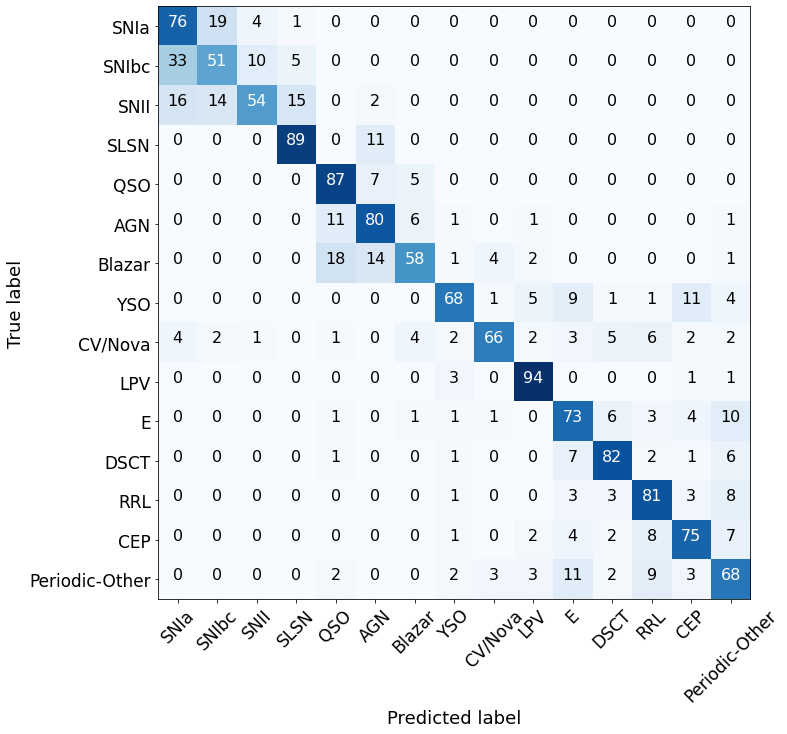

In [26]:
#multiclass conf matrix


plot_confusion_matrix(np.median(array_cnf_matrix,axis=0),label_order,'../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_noWISE.pdf')